# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

- Uses Python to generate synthetic data
- Uses R for evaluation 

In [2]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [49]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [50]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [51]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

In [68]:
model = CTGANSynthesizer()
model.fit(df, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

In [69]:
synth_df = model.sample(1000)

In [73]:
synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,33,72,117,3.305693,3.933615
1,1,64,65,121,3.479289,3.661572
2,1,51,75,102,3.139655,3.808304
3,1,64,80,119,2.837041,3.717887
4,1,80,64,145,3.476595,2.666414


In [74]:
# Output
synth_output = "./synth_data/ctgan_method.csv"

In [75]:
synth_df.to_csv(synth_output, sep=",")

## Evaluation

Sometimes R is used for evaluating utility as it's easy to use the statistics functions

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

In [22]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Table propensity score

Categorical variable count for sex.

Since we have equal table sizes, we can calculate the propensity score:

$$
p_i = \frac{s_i}{s_i + y_i}
$$

- $i$ is a categorical variable
- $p$ is the propensity score
- $s$ is the count for synthetic data
- $y$ is the count for real/original data

In [89]:
%%R -i df,synth_df

suppressMessages(library(dplyr))

real_n <- df %>%
    count(sex) %>%
    mutate(freq = n / sum(n))
    
male_n <- real_n[which(real_n$sex == 1), "n"]
female_n <- real_n[which(real_n$sex == 2), "n"]

synth_n <- synth_df %>%
    count(sex) %>%
    mutate(freq = n / sum(n),
          p_score = case_when(sex == 1 ~ n / (n + male_n),
                             sex == 2 ~ n / (n + female_n)))

print("Frequency of sex: Real")
print(real_n)
print("Frequency of sex: Synthetic")
print(synth_n)

[1] "Frequency of sex: Real"
  sex   n  freq
1   1 516 0.516
2   2 484 0.484
[1] "Frequency of sex: Synthetic"
  sex   n  freq   p_score
1   1 529 0.529 0.5062201
2   2 471 0.471 0.4931937


Since propensity score for sex is near 0.5, we can see the distribution of sex is similar between synthetic vs. real data.

### Using Synthpop

First, we visualise the univariate distributions for each variable.


Comparing percentages observed with synthetic

Press return for next variable(s): 


Selected utility measures:
            S_pMSE df
sex       0.677372  1
sat_v    72.122627  4
sat_m    94.920893  4
sat_sum  92.463103  4
hs_gpa  119.804384  4
fy_gpa   74.855955  4


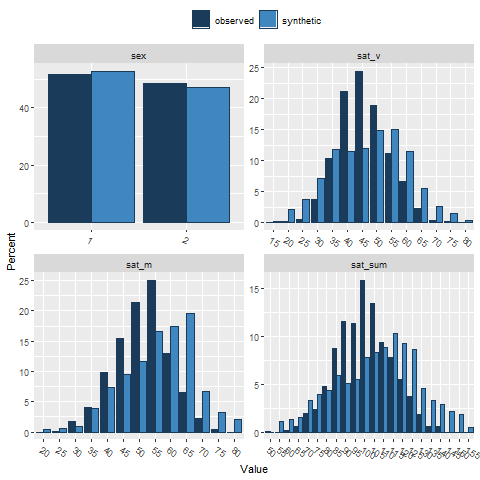

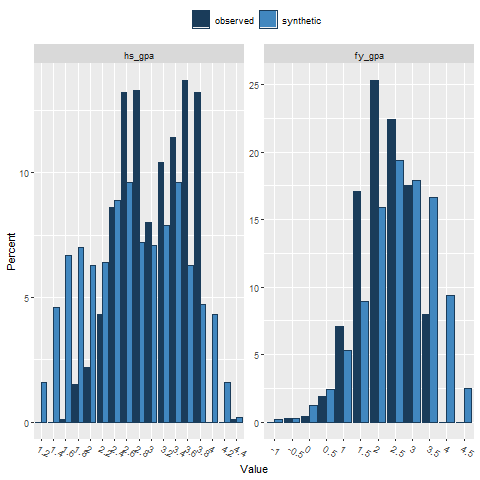

In [102]:
%%R -i df,synth_df

library(synthpop)

compare(synth_df, df, utility.stats = c("S_pMSE", "df"))

Next we do...

Propensity mean squared error (pMSE).

Visualises utility for all two-way tables.

A higher utility score is worse.


Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
3.sat_m:4.sat_sum    1.sex:5.hs_gpa 2.sat_v:4.sat_sum   1.sex:4.sat_sum 
          63.8105           56.6619           54.7733           43.6127 
    1.sex:3.sat_m 
          43.3808 

Table of selected utility measures
                          VW        FT    JSD SPECKS  WMabsDD        U
1.sex:2.sat_v       343.3281  357.7190 0.0636  0.255  61.5157 665441.0
1.sex:3.sat_m       390.4272  419.3243 0.0737  0.248  63.5488 669528.5
1.sex:4.sat_sum     392.5139  411.4643 0.0730  0.274  67.4591 675795.0
1.sex:5.hs_gpa      509.9574  573.9945 0.0991  0.280  69.9777 687125.5
1.sex:6.fy_gpa      313.3263  334.6170 0.0590  0.216  54.0907 645860.5
2.sat_v:3.sat_m     750.0031  870.5094 0.1480  0.378 151.2101 744917.5
2.sat_v:4.sat_sum  1314.5602 1935.0688 0.2863  0.482 198.9882 824099.0
2.sat_v:5.hs_gpa    862.1939  982.9102 0.1686  0.421 164.9066 759756.0
2.sat_v:6.fy_g

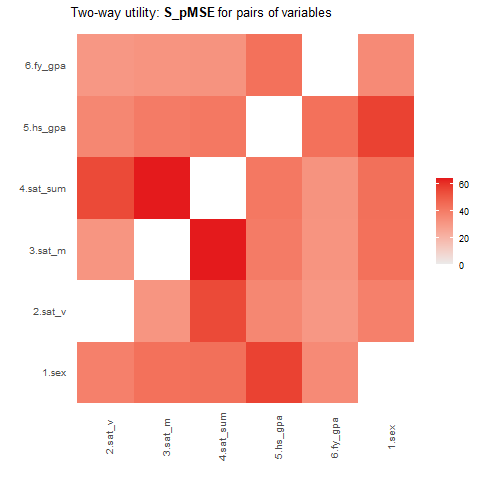

In [104]:
%%R -i df,synth_df

utility.tables(synth_df, df, tab.stats = "all", tables = "twoway", print.tabs = TRUE)

In [94]:
%%R

?utility.tables

In [71]:
%%R -i df,synth_df
# Imports both dataframes from global environment

# Does high school GPA predict first year uni GPA?
real_coeff <- lm(hs_gpa ~ fy_gpa, data = df)
synth_coeff <- lm(hs_gpa ~ fy_gpa, data = synth_df)

print(real_coeff)
print(synth_coeff)

# Confidence interval overlap
ci_real_low <- confint(real_coeff, 'fy_gpa', level=0.95)[1]
ci_real_high <- confint(real_coeff, 'fy_gpa', level=0.95)[2]
ci_synth_low <- confint(synth_coeff, 'fy_gpa', level=0.95)[1]
ci_synth_high <- confint(synth_coeff, 'fy_gpa', level=0.95)[2]

cat(ci_real_low, ci_real_high, ci_synth_low, ci_synth_high)

io <- 0.5 * (
    (min(ci_real_high, ci_synth_high) - max(ci_real_low, ci_synth_low))/(ci_real_high - ci_real_low) +
    (min(ci_real_high, ci_synth_high) - max(ci_real_low, ci_synth_low))/(ci_synth_high - ci_synth_low)
)

print(io)


Call:
lm(formula = hs_gpa ~ fy_gpa, data = df)

Coefficients:
(Intercept)       fy_gpa  
     2.2176       0.3973  


Call:
lm(formula = hs_gpa ~ fy_gpa, data = synth_df)

Coefficients:
(Intercept)       fy_gpa  
     2.2605       0.1869  

0.3591505 0.4354067 0.1390901 0.2347514[1] -1.465871


[1] 0.04433257


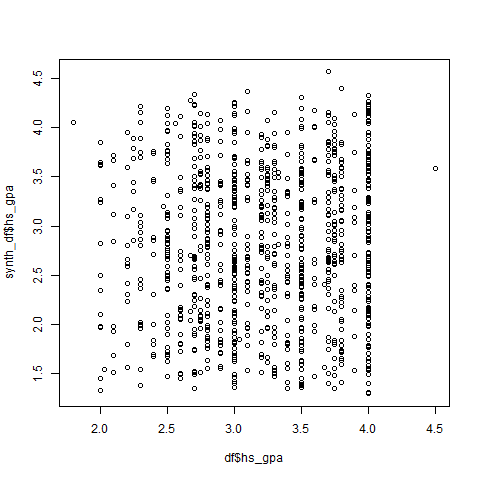

In [72]:
%%R -i df,synth_df
# Imports both dataframes from global environment

print(cor(df$hs_gpa, synth_df$hs_gpa))
plot(df$hs_gpa, synth_df$hs_gpa, type = "p")